In [1]:
from osgeo import gdal,ogr,osr
import os
import numpy as np
import matplotlib.pyplot as plt
#import spectral
#import rasterio
#import spectral.io.envi as envi
#import json
import math
from math import sqrt
import pandas as pd
import geopandas as gpd
import affine
from affine import Affine

In [2]:
file_dir = os.path.join(os.getcwd(),"file")

#input_dir = os.path.join(os.getcwd(),"input","clipped_img")
#file = os.path.join(input_dir,"clipped_img")
input_dir = os.path.join(os.getcwd(),"input","ang20180812t232708rfl")
file = os.path.join(input_dir,"ang20180812t232708_rfl_v2r2_img")
hdr_file = os.path.join(input_dir,"ang20180812t232708_rfl_v2r2_img.hdr")
output_dir = os.path.join(os.getcwd(),"output")

In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	659
Rows (y-axis):	9426


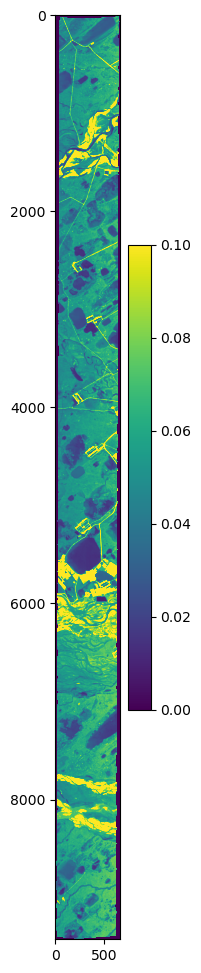

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [6]:
# Read header file and get the metadata
def read_envi_header(file_path):
    metadata = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if " = " in line:
                key, value = line.strip().split(" = ", 1)
                metadata[key.strip()] = value.strip().strip('{}')
            elif line.strip().endswith('}'):
                # Multi-line metadata
                key, value = lines[lines.index(line) - 1].strip().split(" = ", 1)
                metadata[key.strip()] += line.strip().strip('{}')
    return metadata

metadata = read_envi_header(hdr_file)
#metadata

In [7]:
# save a few key meta data features into variables
map_info = metadata.get("map info")
#print(f"Map info: {map_info}")

samples = metadata.get("samples")
#print(f"Samples: {samples}")

wavelength = metadata.get("wavelength")
#print(f"Wavelength: {wavelength}")

In [1]:
# define plot site file path and read as a geopandas df
plot_site_input_dir = os.path.join(os.getcwd(),"input","32_Prudhoe_Bay_ARCSEES_Road_Study_0")
plot_site_file = os.path.join(plot_site_input_dir,"32_Prudhoe_Bay_ARCSEES_Road_Study_0.shp")
print(plot_site_file)

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
plot_sites = driver.Open(plot_site_file, 0)

plot_sites_geojson = gpd.read_file(plot_site_file)
plot_sites_geojson.head(5)

NameError: name 'os' is not defined

In [9]:
plot_site_input_dir = os.path.join(os.getcwd(),"input","plot_sites")
plot_site_file_path = os.path.join(plot_site_input_dir,"32_Prudhoe_Bay_ARCSEES_Road_Study_0.geojson")
print(plot_site_file_path)

plot_sites_geojson = gpd.read_file(plot_site_file_path)
plot_sites_geojson.head(5)

/Users/patrickangst/Documents/GitHub/UWW200_Master_Thesis_public/code/input/plot_sites/32_Prudhoe_Bay_ARCSEES_Road_Study_0.geojson


,Turboveg_releve_number,Field_releve_number,Modified_releve_number_for_plot,Date__year_month_day_,Year_plot_surveyed,Dataset,Surveyed_by__PI_of_project_,lat,lon,System_for_plant_community_name,Plant_community_name,Habitat_Type,Number_of_species,Ancillary_data_available,Cover_abundance_scale,image_url1,image_url2,image_url3,ObjectId,geometry
0,12763,T1-005-C,T1-005-C,20140807,2014,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22318,-148.4714,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,1,POINT (-148.47141 70.22318)
1,12764,T1-005-C,T1-005-T,20140807,2014,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22322,-148.4717,Field community name,"Wet Carex aquatilis, Drepanocladus brevifolius...","Wet nonacidic tundra (Carex spp., Eriophorum s...",None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,2,POINT (-148.47168 70.22322)
2,12765,T1-005-C,T1-010-C,20140806,2014,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22323,-148.4714,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,3,POINT (-148.47136 70.22323)
3,12766,T1-010-T,T1-010-T,20140806,2014,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22330,-148.4717,Field community name,"Wet Carex aquatilis, Drepanocladus brevifolius...","Wet nonacidic tundra (Carex spp., Eriophorum s...",None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,4,POINT (-148.47173 70.22329)
4,12767,T1-025-C,T1-025-C,20140806,2014,Prudhoe Bay ArcSEES (Walker et al. 2015),Donald A. 'Skip' Walker,70.22334,-148.4711,Field community name,"Moist Carex aquatilis, Ochrolechia frigida gra...",Moist nonacidic tundra (Sedge-Dryas-Tomentypnu...,None,"Soil, Sepctral (LAI) data",Old Braun-Blanquet,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,http://static.gina.alaska.edu/geobotany/pb_arc...,5,POINT (-148.47110 70.22333)


In [10]:
# Check if CRS is None and assign a default if necessary
if plot_sites_geojson.crs is None:
    print("CRS information is missing, assigning default CRS (EPSG:4326)")
    plot_sites_geojson.set_crs(epsg=4326, inplace=True)

plot_site_crs = plot_sites_geojson.crs.to_epsg()

# Print the EPSG code
print("EPSG Code Plot Sites:", plot_site_crs)

EPSG Code Plot Sites: 4326


# Iterate using itertuples
for row in plot_sites_geojson.itertuples():
    print(f"Index: {row.Index}")
    print(f"Field_rele: {row.Field_rele}")
    print(f"Modified_r: {row.Modified_r}")
    print(f"Plant_comm: {row.Plant_comm}")
    print(f"Habitat_Ty: {row.Habitat_Ty}")
    print(f"Longitude: {row.lon}")
    print(f"Latitude: {row.lat}")
    print(f"geometry: {row.geometry}")
    print('---')


In [11]:
# Get the projection
projection = img_open.GetProjection()

# Create a spatial reference object
srs = osr.SpatialReference()
srs.ImportFromWkt(projection)

# Print the projection in various formats
print("WKT Projection:")
print(srs.ExportToWkt())

print("Proj4 Projection:")
print(srs.ExportToProj4())

srs.AutoIdentifyEPSG()
hs_crs = srs.GetAuthorityCode(None)

# Print the EPSG code
print("EPSG Code Hyperspectral Image:", hs_crs)

WKT Projection:
PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Proj4 Projection:
+proj=utm +zone=6 +datum=WGS84 +units=m +no_defs
EPSG Code Hyperspectral Image: 32606


In [12]:
# shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
lyr = plot_sites.GetLayer() # get the only layer in the shapefile
feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
geom = feat.GetGeometryRef()      # get the feature's geometry

# get transform for decimal degrees
from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
to_srs = osr.SpatialReference()                                        # init ogr srs object
to_srs.ImportFromEPSG(int(hs_crs))                                            # import wgs84 srs def
xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object

# get UTM and lat/long coordinates for each of the sites
utm_coordinate_pairs = {}
ll_coordinate_pairs = {}
for feature in lyr:
    geom = feature.GetGeometryRef()                                    # get site geometry
    utm_coordinate_pairs[feature['Modified_r']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
    geom.Transform(xytransform)                                        # to wgs84
    ll_coordinate_pairs[feature['Modified_r']] = (geom.GetX(), geom.GetY())  # get lon, lat
    
# get the x and y UTM coordinates for the first site
x, y = ll_coordinate_pairs['T1-010-C']
affine_transform = affine.Affine.from_gdal(*img_open.GetGeoTransform())     # affine forward transform
inverse_transform = ~affine_transform                                  # invert transform
px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers

# print the three coordinates (UTM, geographic, image)
print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
       " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['T1-010-C']),
       " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

Site 1 UTM coordinates (x,y): 				(444442.206750331, 7791438.30370725)
 are equal to geographic coordinates (lng,lat): 	(444442.206750331, 7791438.30370725)
 and fall within image coordinates (pixel,line):	(468, 5352)


In [13]:
plot_site_pixel_coordinates = pd.DataFrame(columns = ["Modified_r", "lon", "lat", "pixel_x", "pixel_y"])

for site, coords in ll_coordinate_pairs.items():
    lon, lat = coords
    px, py = inverse_transform * (lon, lat)                                    # apply to x,y coordinates
    px, py = round(px), round(py)                                  # get new x,y as integers
    plot_site_pixel_coordinates = plot_site_pixel_coordinates._append({'Modified_r' : site, 'lon' : lon, 'lat' : lat, 'pixel_x' : px, 'pixel_y' : py},
        ignore_index = True)

/var/folders/3m/0hcxmtys0jj01y_svh59k5fm0000gn/T/ipykernel_1438/3695146767.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_site_pixel_coordinates = plot_site_pixel_coordinates._append({'Modified_r' : site, 'lon' : lon, 'lat' : lat, 'pixel_x' : px, 'pixel_y' : py},


In [14]:
plot_site_pixel_coordinates.head(5)

,Modified_r,lon,lat,pixel_x,pixel_y
0,T1-005-C,444440.243453,7.791433e+06,467,5352
1,T1-005-T,444430.247575,7.791438e+06,466,5350
2,T1-010-C,444442.206750,7.791438e+06,468,5352
3,T1-010-T,444428.536060,7.791446e+06,468,5349
4,T1-025-C,444452.379537,7.791450e+06,470,5352


In [15]:
# Dictionary containing band descriptions
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# Function to classify bands based on their wavelength
def classify_band(wavelength):
    for region, limits in band_dictionary.items():
        if limits['lower'] < wavelength <= limits['upper']:
            return region
    return None

# Extracting metadata keys and values
metadata_keys = img_open.GetMetadata().keys()
metadata_values = img_open.GetMetadata().values()


# Lists of band numbers and band centers
band_numbers = [
    int(key.split("_")[1])
    for key in metadata_keys
    if key != "wavelength_units"
]

band_centers = [
    float(value.split(" ")[0])
    for value in metadata_values
    if value != "Nanometers"
]

# Classify each band center
em_regions = [classify_band(b) for b in band_centers]


# get the reflectance values of the site (careful: these values are already sorted --> add to df after sort)
#testsite1_reflectance = img_open.ReadAsArray(px1,py1,1,1).flatten().tolist()
#testsite2_reflectance = img_open.ReadAsArray(px2,py2,1,1).flatten().tolist()


# Function to get reflectance for each site
def get_site_reflectance(px, py):
    reflectance = img_open.ReadAsArray(px,py,1,1).flatten()
    return reflectance

# Apply the function to each row and add the result as a new column
plot_site_pixel_coordinates['reflectance'] = plot_site_pixel_coordinates.apply(lambda row: get_site_reflectance(row['pixel_x'], row['pixel_y']), axis=1)


In [16]:
# DataFrame describing bands
bands = pd.DataFrame({
    "Band number": band_numbers,
    "Band center (nm)": band_centers,
    "EM region": em_regions
}, index=band_numbers).sort_index()


# Iterate over rows
for row in plot_site_pixel_coordinates.itertuples():
    bands[f"{row.Modified_r} Reflectance"] = row.reflectance


In [17]:
bands.query("`Band number` == 57")

,Band number,Band center (nm),EM region,T1-005-C Reflectance,T1-005-T Reflectance,T1-010-C Reflectance,T1-010-T Reflectance,T1-025-C Reflectance,T1-025-T Reflectance,T1-050-C Reflectance,...,T2-050-T Reflectance,T2-100-C Reflectance,T2-100-T Reflectance,T2-200-C Reflectance,T2-200-T Reflectance,14-1 Reflectance,14-2 Reflectance,14-3 Reflectance,14-4 Reflectance,14-5 Reflectance
57,57,657.35,visible-red,0.071085,0.070749,0.068342,0.063858,0.057512,0.047522,0.063546,...,0.046451,0.057417,0.062308,0.054479,0.057781,0.129935,0.117735,0.076377,0.070272,0.067713


### Create a reflectance plot for the 2 test sites

It can be seen that in the region of arround 1300 nanometer and towards the end we have a lot of noise. In the next step this will be removed manualy.

### Create a plot with noise bands removed

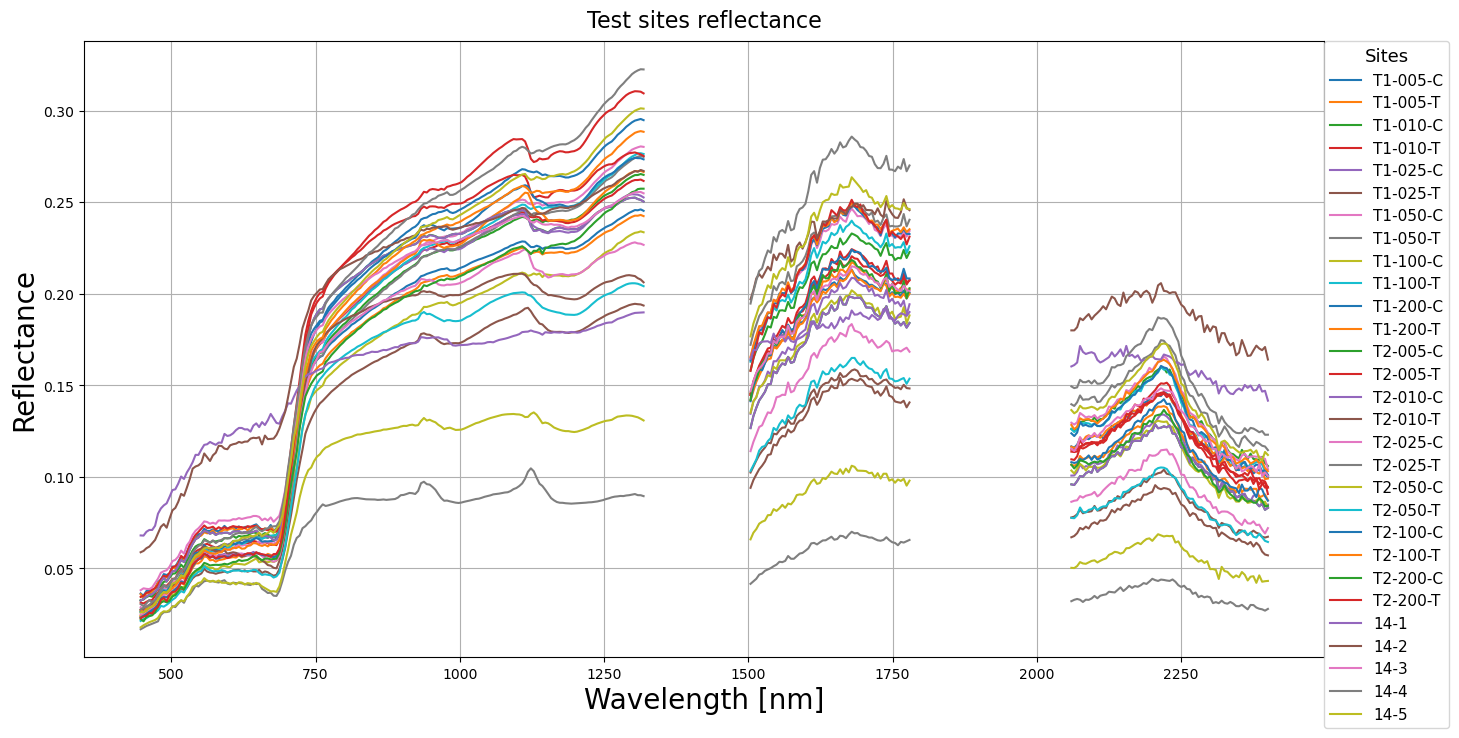

In [18]:
# remove a few band to reduce atmospheric noise 
wavelengths = bands["Band center (nm)"]
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0


titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

# Iterate over rows
for row in plot_site_pixel_coordinates.itertuples():
    pixel = img_open.ReadAsArray(row.pixel_x, row.pixel_y, 1, 1)
    pixel = np.reshape(pixel,(425))
    pixel[bblist == 0] = np.nan
    plt.plot(wavelengths, pixel,  label = row.Modified_r)

plt.xlabel ( 'Wavelength [nm]', fontsize=20)
#plt.ylim(y_min, y_max)
plt.ylabel('Reflectance', fontsize=20)
plt.title("Test sites reflectance", fontdict = titlefont, pad = 10)
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Sites', title_fontsize='13', fontsize='11', borderaxespad=0.)


plt.show()

### Create the same plot with wavelength indicators

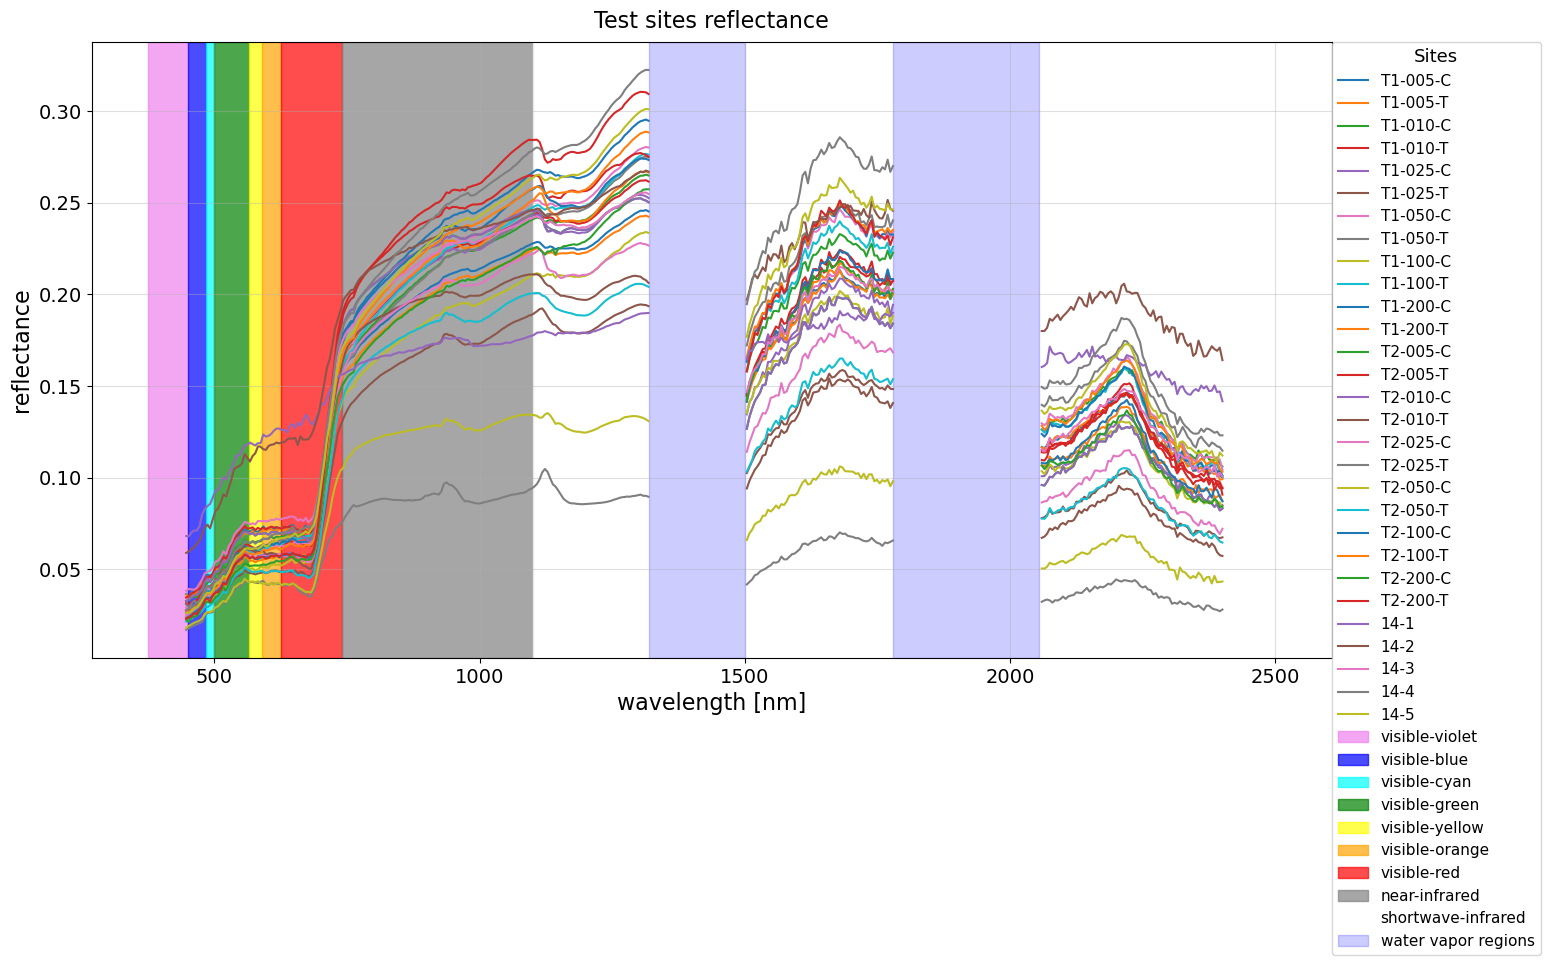

In [19]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

# Iterate over rows
for row in plot_site_pixel_coordinates.itertuples():
    pixel = img_open.ReadAsArray(row.pixel_x, row.pixel_y, 1, 1)
    pixel = np.reshape(pixel,(425))
    pixel[bblist == 0] = np.nan
    plt.plot(wavelengths, pixel,  label = row.Modified_r)


# add shaders for band regions
for region,limits in band_dictionary.items():
    plt.axvspan(limits['lower'], limits['upper'], alpha=0.7, color=limits['color'], label=region)
        
# add water vapor region shaders
plt.axvspan(1320, 1500, alpha=0.2, color='blue', label='water vapor regions')
plt.axvspan(1780, 2055, alpha=0.2, color='blue')
    
# some plotting config
#plt.ylim(y_min,y_max)
#plt.xlim(min(wavelengths),max(wavelengths))
plt.ylabel("reflectance", fontsize=16)
plt.xlabel("wavelength [nm]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid('on', alpha=0.4)
plt.title("Test sites reflectance", fontdict = titlefont, pad = 10)

# now add custom legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Sites', title_fontsize='13', fontsize='11', borderaxespad=0.)